In [71]:
import pandas as pd
import numpy as np
import folium 
from shapely.geometry import Point
import geopandas as gpd
from cartiflette import carti_download
import matplotlib.pyplot as plt

In [72]:
# =================================================================
# 1. CHARGEMENT DES DÉPARTEMENTS ET PRÉPARATION
# =================================================================

# Chargement des départements
departements = carti_download(
    values=["France"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Filtrage France métropolitaine
departements = departements.loc[departements['INSEE_DEP'] < '970'] 
departements_proj = departements.to_crs(epsg=2154)  # Reprojection en Lambert-93


In [73]:
import pandas as pd
import os
import sys

# Définition du nom de fichier que nous avons créé précédemment
NOM_FICHIER_DESIRE = "df_clean.csv"
chemin_complet = os.path.join(os.getcwd(), NOM_FICHIER_DESIRE)

# --- 1. Importer le fichier CSV ---
try:
    # Lecture du fichier CSV
    # Nous utilisons 'index_col=0' car l'exportation précédente (index=True) 
    # a généralement transformé l'ancien MultiIndex (time, lat, lon) en première colonne.
    df_puy_de_dome = pd.read_csv(chemin_complet, index_col=0) 
    print(f"✅ Fichier '{NOM_FICHIER_DESIRE}' importé avec succès dans 'df_puy_de_dome'.")

except FileNotFoundError:
    print(f"❌ Erreur : Le fichier CSV est introuvable à l'emplacement : {chemin_complet}")
    print("Veuillez vous assurer que le script d'exportation a été exécuté correctement.")
    sys.exit(1)
except Exception as e:
    print(f"❌ Erreur lors de l'importation du CSV : {e}")
    sys.exit(1)


✅ Fichier 'df_clean.csv' importé avec succès dans 'df_puy_de_dome'.


In [74]:
df_puy_de_dome.head(10)

,latitude,longitude,skt,sd,swvl1,skt_C
time,,,,,,
2000-01-01,47.0,2.0,276.47827,0.000028,0.385925,3.328278
2000-01-01,47.0,2.1,276.46265,0.000029,0.386719,3.312653
2000-01-01,47.0,2.2,276.42358,0.000030,0.386246,3.273590
2000-01-01,47.0,2.3,276.31616,0.000031,0.386902,3.166168
2000-01-01,47.0,2.4,276.22240,0.000033,0.387482,3.072418
2000-01-01,47.0,2.5,276.12670,0.000038,0.388031,2.976715
2000-01-01,47.0,2.6,276.01733,0.000045,0.388809,2.867340
2000-01-01,47.0,2.7,275.95483,0.000053,0.388855,2.804840
2000-01-01,47.0,2.8,275.94310,0.000065,0.388809,2.793121


In [75]:
# Cr"ation du dataframe geopandas
gdf_geo_puy_de_dome = gpd.GeoDataFrame(
    df_puy_de_dome,
    geometry=gpd.points_from_xy(df_puy_de_dome['longitude'], df_puy_de_dome['latitude']),
    crs="EPSG:4326"
)
gdf_geo_puy_de_dome = gdf_geo_puy_de_dome.to_crs(departements_proj.crs)

In [76]:
gdf_geo_puy_de_dome.index

Index(['2000-01-01', '2000-01-01', '2000-01-01', '2000-01-01', '2000-01-01',
       '2000-01-01', '2000-01-01', '2000-01-01', '2000-01-01', '2000-01-01',
       ...
       '2024-12-01', '2024-12-01', '2024-12-01', '2024-12-01', '2024-12-01',
       '2024-12-01', '2024-12-01', '2024-12-01', '2024-12-01', '2024-12-01'],
      dtype='object', name='time', length=288300)

In [77]:
gdf_geo_puy_de_dome.columns

Index(['latitude', 'longitude', 'skt', 'sd', 'swvl1', 'skt_C', 'geometry'], dtype='object')

In [78]:
# On viens prendre les données d'une année en particulier, par exemple 2000 et 2001
gdf_geo_puy_de_dome.index = pd.to_datetime(gdf_geo_puy_de_dome.index)
gdf_2000 = gdf_geo_puy_de_dome[gdf_geo_puy_de_dome.index.year == 2000]
gdf_geo_puy_de_dome.index = pd.to_datetime(gdf_geo_puy_de_dome.index)
gdf_2007 = gdf_geo_puy_de_dome[gdf_geo_puy_de_dome.index.year == 2007]

gdf_2000.index = gdf_2000.index.strftime("%d/%m")
gdf_2007.index = gdf_2007.index.strftime("%d/%m")

In [79]:
# calcule de la différence entre les 2 années en conservant la latitude et longitude associées
df_diff = gdf_2000[["longitude", "latitude","geometry"]].copy()
df_diff["skt_diff"] = gdf_2000["skt"] - gdf_2007["skt"]
gdf_geo_puy_de_dome = gpd.GeoDataFrame(
    df_diff,
    geometry=gpd.points_from_xy(df_diff['longitude'], df_diff['latitude']),
    crs="EPSG:4326"
)

In [80]:
df_diff.head()

,longitude,latitude,geometry,skt_diff
time,,,,
01/01,2.0,47.0,POINT (624015.535 6656012.01),-2.58583
01/01,2.1,47.0,POINT (631613.635 6655920.592),-2.57019
01/01,2.2,47.0,POINT (639211.843 6655838.797),-2.54480
01/01,2.3,47.0,POINT (646810.15 6655766.625),-2.38269
01/01,2.4,47.0,POINT (654408.541 6655704.076),-2.33973


In [81]:
#FILTRAGE SPATIAL SUR LE PUY-DE-DÔME
departement_63 = departements_proj[departements_proj['INSEE_DEP'] == '63'].copy()

points_diff_63 = gpd.sjoin(
    df_diff, 
    departement_63[['INSEE_DEP', 'geometry']],
    predicate="within"
)

points_diff_63 = points_diff_63.to_crs(epsg=4326)
departement_63 = departement_63.to_crs(epsg=4326)

In [82]:
points_diff_63.head()

,longitude,latitude,geometry,skt_diff,index_right,INSEE_DEP
time,,,,,,
01/01,2.9,46.2,POINT (2.9 46.2),-3.12293,18,63
01/01,2.6,46.1,POINT (2.6 46.1),-3.13464,18,63
01/01,2.7,46.1,POINT (2.7 46.1),-3.14831,18,63
01/01,2.8,46.1,POINT (2.8 46.1),-3.20497,18,63
01/01,2.9,46.1,POINT (2.9 46.1),-3.27528,18,63


In [83]:
# =================================================================
# 4. CALCUL DU CENTRE POUR LA CARTE
# =================================================================

bounds = departement_63.total_bounds  # [minx, miny, maxx, maxy]
CENTER_LON = (bounds[0] + bounds[2]) / 2
CENTER_LAT = (bounds[1] + bounds[3]) / 2


In [92]:
import branca.colormap as cm



# Création d'un colormap 
colormap = cm.linear.RdYlBu_11.scale(
    df_diff["skt_diff"].min(),
    df_diff["skt_diff"].max()
)
# Normaliser les valeurs
min_val = df_diff["skt_diff"].min()
max_val = df_diff["skt_diff"].max()


for dates in points_diff_63.index.unique():
    m = folium.Map(
            location=[CENTER_LAT, CENTER_LON], 
            zoom_start=9, 
            tiles="CartoDB positron"
            )
    # Bordure du département
    folium.GeoJson(
        departement_63,
        style_function=lambda x: {
            'fillColor': 'none',
            'color': 'red',
            'weight': 2,
            'fillOpacity': 0
        },
        name="Puy-de-Dôme (63)"
    ).add_to(m)
    colormap.add_to(m)
    for i in range(len(points_diff_63.loc[dates, "skt_diff"])):
        val = points_diff_63.loc[dates, "skt_diff"][i]
        lat = points_diff_63.loc[dates, "latitude"][i]
        lon = points_diff_63.loc[dates, "longitude"][i]
        
        color = colormap(-(val- min_val / (max_val - min_val)))
        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.8
        ).add_to(m)
        
    dates_formatted = dates.replace("/", ".")
    m.save(f"carte_date_2000-2007/carte_puy_de_dome_difference{dates_formatted}.html")






# m.save("carte_date_t/carte_puy_de_dome_difference.html")
# print("\nCarte sauvegardée : carte_puy_de_dome_difference_amas.html")

#m

C:\Users\loicd\AppData\Local\Temp\ipykernel_15940\1081324055.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = points_diff_63.loc[dates, "skt_diff"][i]
C:\Users\loicd\AppData\Local\Temp\ipykernel_15940\1081324055.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lat = points_diff_63.loc[dates, "latitude"][i]
C:\Users\loicd\AppData\Local\Temp\ipykernel_15940\1081324055.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

C:\Users\loicd\AppData\Local\Temp\ipykernel_15940\1454633222.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


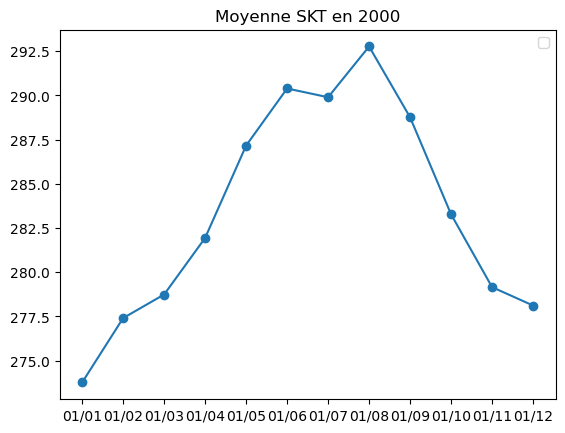

In [85]:
# Donnée de forme gaussienne
dates = gdf_2000.index.unique()
moy_skt_2000 = []
moy_sd_2000 = []
moy_swvl1_2000 = []
moy_skt_C_2000 = []
for date in dates:
    val_date = gdf_2000[gdf_2000.index == date]
    moy_skt_2000.append(val_date["skt"].mean())
    moy_sd_2000.append(val_date["sd"].mean())
    moy_swvl1_2000.append(val_date["swvl1"].mean())
    moy_skt_C_2000.append(val_date["skt_C"].mean())

plt.plot(dates, moy_skt_2000,marker='o')
plt.title("Moyenne SKT en 2000")
plt.legend()

C:\Users\loicd\AppData\Local\Temp\ipykernel_15940\2409258887.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


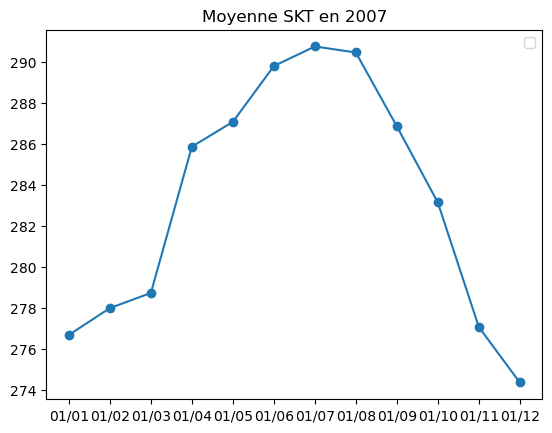

In [90]:
# Donnée de forme gaussienne
dates = gdf_2007.index.unique()
moy_skt_2007 = []
for date in dates:
    val_date = gdf_2007[gdf_2007.index == date]
    moy_skt_2007.append(val_date["skt"].mean())
    
plt.plot(dates, moy_skt_2007,marker='o')
plt.title("Moyenne SKT en 2007")
plt.legend()